In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
import pickle

from ds import Datas

In [2]:
# LOAD Datas()
file = open("../data/PO_part3_ra05.txt", "rb")
data = pickle.load(file)
file.close()

print(np.shape(data.is_optimum))

(7, 200, 2)


## Analysis

In [3]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ["o", ">", "s"]
M_strategies = ["our_M", "qiskit_M"]
#M_strategies = [r"$\tilde{M}$", "$M_q$", "$M_{opt}$"]
plot_M = [1, 1]

## M value

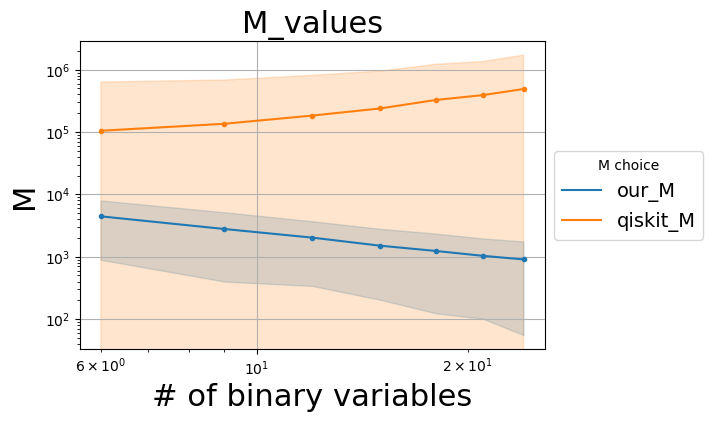

In [4]:
def statistics_M(data):
    avg = np.mean(data.M[:,:,:], axis = 1)
    std = np.std(data.M[:,:,:], axis = 1)
    return avg, std

avg_M, std_M = statistics_M(data)

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('M_values', fontsize = 22)
ax1.set_xlabel('# of binary variables', fontsize = 22)
ax1.set_ylabel('M', fontsize = 22)
for i in range(len(M_strategies)):
    if plot_M[i]:
        plt.plot(data.bvars, avg_M[:,i], color = colors[i], label=M_strategies[i])
        plt.plot(data.bvars, avg_M[:,i], ".", color = colors[i])
        plt.fill_between(data.bvars, avg_M[:,i] - std_M[:,i], avg_M[:,i] + std_M[:,i], color = colors[i], alpha=.2)
        """ for var_idx in range(len(data.bvars)):
            y = data.M[var_idx, :, i]
            x = data.bvars[var_idx] * np.ones((len(y)))
            plt.scatter(x, y, color = colors[i], alpha=.3) """
plt.grid()
#plt.ylim(0, 50)
#plt.xlim(5, 10)
plt.yscale("log")
plt.xscale("log")
ax1.legend(title = 'M choice', fontsize = 14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Fitting M

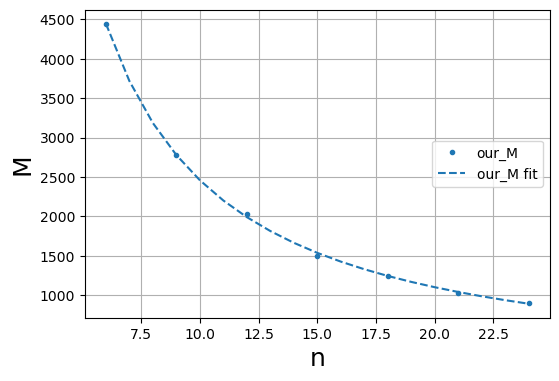

Our fit:	35479.8x+-1.16
35479.79559126507 \pm 715.4222053062492
-1.159260538506154 \pm 0.0093411766526497
Qiskit fit:	7288.22x+1.32
7288.215245477705 \pm 1770.1839106547757
1.3150245430548595 \pm 0.08166580465662425


In [5]:
f = lambda n, a, b: a*n + b
f2 = lambda n, a, b: a*n**2 + b*n
f_pl = lambda n, a, b : a*n**b
funct = f_pl

n_parameters = 2
_, _, n_M = np.shape(data.is_feasible)

start_point = 0

coef = np.ndarray((n_parameters, 3))
coef_cov = np.ndarray((n_parameters, n_parameters, 3))
coef_err = np.ndarray((n_parameters, 3))
for i in range(n_M):
    coef[:,i], coef_cov[...,i] = sp.optimize.curve_fit(funct, data.bvars[start_point:], avg_M[start_point:,i])
    coef_err[:,i] = np.sqrt( np.diag(coef_cov[...,i]) )

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
#ax1.set_title('M_values', fontsize = 22)
ax1.set_xlabel('n', fontsize = 18)
ax1.set_ylabel('M', fontsize = 18)
for i in range(n_M-1):
    if plot_M[i]:
        plt.plot(data.bvars, avg_M[:,i], ".", color = colors[i], label=M_strategies[i])
        #plt.fill_between(data.bvars, avg_M[:,i] - std_M[:,i], avg_M[:,i] + std_M[:,i], color = colors[i], alpha=.2)
        plt.plot(np.arange(data.bvars[0], data.bvars[-1] + 1),
                funct(np.arange(data.bvars[0], data.bvars[-1] + 1), *coef[:,i]), "--",
                color = colors[i], label=M_strategies[i]+" fit")
""" plt.plot(data_opt.bvars, avg_M_opt[:,0], ".", color = colors[2], label="optimal")
plt.fill_between(data_opt.bvars, avg_M_opt[:,0] - std_M_opt[:,0], avg_M_opt[:,0] + std_M_opt[:,0], color = colors[2], alpha=.2)
plt.plot(data_opt.bvars, funct(data_opt.bvars, *coef[:,2]), "--", color = colors[2], label="optimal"+"_fit")
 """
plt.grid()
#plt.ylim(0, 250)
#plt.yscale("log")
ax1.legend(fontsize = 10, loc='center right')
#ax1.legend(title = 'M choice', fontsize = 14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

words = ["Our", "Qiskit", "Optimal"]
for i in range(n_M):
    print(f"{words[i]} fit:\t{np.round(coef[0,i], 2)}x+{np.round(coef[1,i], 2)}")
    print(f"{coef[0,i]} \pm {coef_err[0,i]}")
    print(f"{coef[1,i]} \pm {coef_err[1,i]}")

## Optimality and Feasibility percentages

In [6]:
def evaluate_optimality(data, opt_threshold = .5):
    n_bvars, n_samples, n_M_strats = np.shape(data.is_feasible)
    for var_idx in range(n_bvars):
        for M_idx in range(n_M_strats):
            for sample in range(n_samples):
                if data.is_feasible[var_idx, sample, M_idx]:
                    fc = data.fval[var_idx, sample, 0, M_idx]
                    fq = data.fval[var_idx, sample, 1, M_idx]
                    if np.abs(fc - fq) < opt_threshold: # optimum
                        data.is_optimum[var_idx, sample, M_idx] = True

def compute_errors(data, threshold_fc_zero = 1e-8):
    n_bvars, n_samples, n_M_strats = np.shape(data.is_feasible)
    is_feas_non_opt = np.logical_xor(data.is_feasible, data.is_optimum)
    for var_idx in range(n_bvars):
        for M_idx in range(n_M_strats):
            for sample in range(n_samples):
                if is_feas_non_opt[var_idx, sample, M_idx] == True:
                    fc = data.fval[var_idx, sample, 0, M_idx]
                    fq = data.fval[var_idx, sample, 1, M_idx]
                    if np.abs(fc) > threshold_fc_zero: 
                        ratio = np.abs( (fq -fc) / fc)
                    else:
                        ratio = None
                    data.relative_error[var_idx, sample, M_idx] = ratio
                    data.absolute_error[var_idx, sample, M_idx] = fq -fc

def statistics_correctness_n_feasability(data):
    '''
    Returns:
        percentage_optimal, percentage_feasible, (avg_relative_error, std_relative_error) [only among feasible non optimal solutions],
        (avg_n_violations, avg_max_violation) [only among non feasible solutions]
    '''
    n_bvars, n_samples, n_M_strats = np.shape(data.is_feasible)
    # percentages
    perc_opt = np.count_nonzero(data.is_optimum, axis=1) / n_samples
    perc_feas = np.count_nonzero(data.is_feasible, axis=1) / n_samples
    # relative errs
    is_feas_non_opt = np.logical_xor(data.is_feasible, data.is_optimum)
    avg_relative_error, std_relative_error = np.zeros((n_bvars, n_M_strats)), np.zeros((n_bvars, n_M_strats))
    for var_idx in range(n_bvars):
        for M_idx in range(n_M_strats):
            relative_errs = data.relative_error[var_idx, :, M_idx][is_feas_non_opt[var_idx, :, M_idx]]
            # discard the None for when fc ~ 0
            relative_errs = relative_errs[~np.isnan(relative_errs)]
            if len(relative_errs) > 0:
                avg_relative_error[var_idx, M_idx] = np.mean(relative_errs)
                std_relative_error[var_idx, M_idx] = np.std(relative_errs)
    # errors
    avg_error, std_error = np.zeros((n_bvars, n_M_strats)), np.zeros((n_bvars, n_M_strats))
    for var_idx in range(n_bvars):
        for M_idx in range(n_M_strats):
            absolute_err = data.absolute_error[var_idx, :, M_idx][is_feas_non_opt[var_idx, :, M_idx]]
            if len(absolute_err) > 0:
                avg_error[var_idx, M_idx] = np.mean(absolute_err)
                std_error[var_idx, M_idx] = np.std(absolute_err)
    # violations
    is_infeas = np.logical_not(data.is_feasible)
    avg_n_violations, avg_max_violation = np.zeros((n_bvars, n_M_strats)), np.zeros((n_bvars, n_M_strats))
    for var_idx in range(n_bvars):
        for M_idx in range(n_M_strats):
            n_viol = data.n_violations[var_idx, :, M_idx][is_infeas[var_idx, :, M_idx]]
            if len(n_viol) > 0:
                max_viol = data.max_violation[var_idx, :, M_idx][is_infeas[var_idx, :, M_idx]]
                avg_n_violations[var_idx, M_idx] = np.mean(n_viol)
                avg_max_violation[var_idx, M_idx] = np.mean(max_viol)
    return perc_opt, perc_feas, (avg_relative_error, std_relative_error), (avg_error, std_error), (avg_n_violations, avg_max_violation)

evaluate_optimality(data)
compute_errors(data)
perc_opt, perc_feas, (avg_relative_error, std_relative_error), (avg_absolute_error, std_absolute_error), (avg_n_violations, avg_max_violation) = statistics_correctness_n_feasability(data)

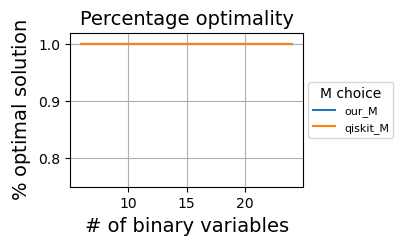

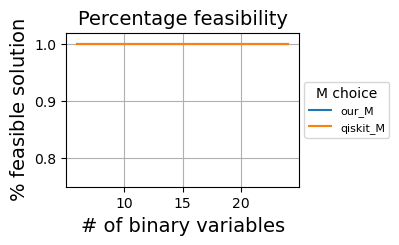

In [7]:
fig = plt.figure(figsize=(3,2))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Percentage optimality', fontsize = 14)
ax1.set_xlabel('# of binary variables', fontsize = 14)
ax1.set_ylabel('$\%$ optimal solution', fontsize = 14)
plt.ylim(0, 1.1)
for i in range(len(M_strategies)):
    if plot_M[i]:
        plt.plot(data.bvars, perc_opt[:,i], label=M_strategies[i])
plt.ylim(.75,1.02)
plt.grid()
ax1.legend(title = 'M choice', fontsize = 8, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

fig = plt.figure(figsize=(3,2))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Percentage feasibility', fontsize = 14)
ax1.set_xlabel('# of binary variables', fontsize = 14)
ax1.set_ylabel('$\%$ feasible solution', fontsize = 14)
plt.ylim(.75,1.02)
for i in range(len(M_strategies)):
    if plot_M[i]:
        plt.plot(data.bvars, perc_feas[:,i], label=M_strategies[i])
plt.grid()
ax1.legend(title = 'M choice', fontsize = 8, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Errors

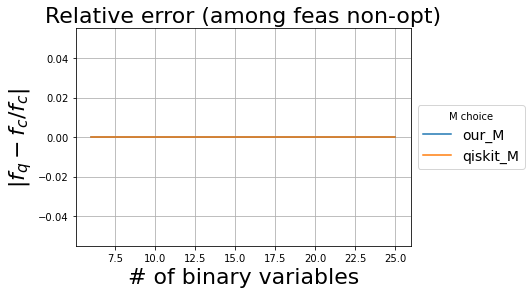

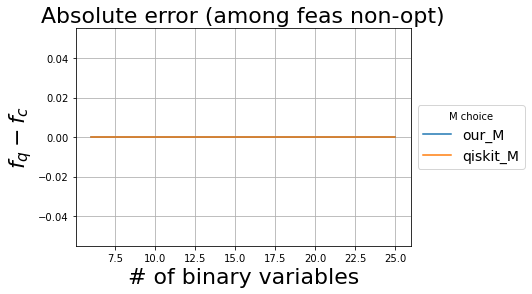

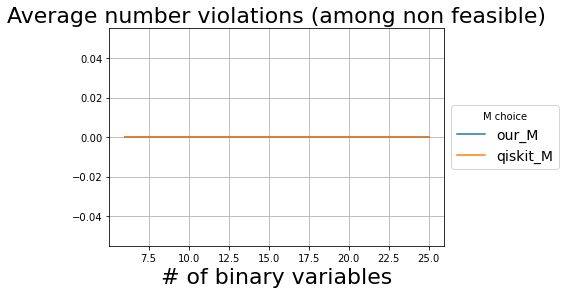

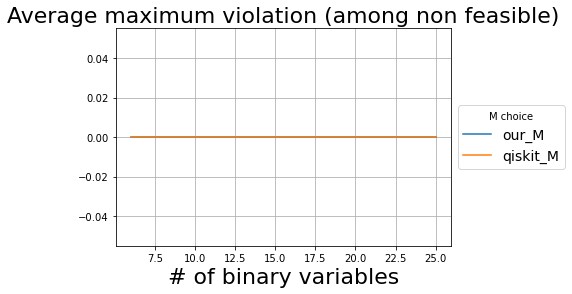

In [114]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Relative error (among feas non-opt)', fontsize = 22)
ax1.set_xlabel('# of binary variables', fontsize = 22)
ax1.set_ylabel('$|f_q-f_c / f_c|$', fontsize = 22)
is_feas_non_opt = np.logical_xor(data.is_feasible, data.is_optimum)
for i in range(len(M_strategies)):
    if plot_M[i]:
        plt.plot(data.bvars, avg_relative_error[:,i], label=M_strategies[i], color = colors[i])
        plt.fill_between(data.bvars, avg_relative_error[:,i] - std_relative_error[:,i], avg_relative_error[:,i] + std_relative_error[:,i], alpha=.2)
#plt.ylim(-1,5)
plt.grid()
ax1.legend(title = 'M choice', fontsize = 14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Absolute error (among feas non-opt)', fontsize = 22)
ax1.set_xlabel('# of binary variables', fontsize = 22)
ax1.set_ylabel('$f_q-f_c$', fontsize = 22)
for i in range(len(M_strategies)):
    if plot_M[i]:
        plt.plot(data.bvars, avg_absolute_error[:,i], label=M_strategies[i], color = colors[i])
        plt.fill_between(data.bvars, avg_absolute_error[:,i] - std_absolute_error[:,i], np.abs(avg_absolute_error[:,i]) + std_absolute_error[:,i], alpha=.2)
#plt.ylim(0,2)
plt.grid()
ax1.legend(title = 'M choice', fontsize = 14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Average number violations (among non feasible)', fontsize = 22)
ax1.set_xlabel('# of binary variables', fontsize = 22)
for i in range(len(M_strategies)):
    if plot_M[i]:
        plt.plot(data.bvars, avg_n_violations[:,i], label=M_strategies[i])
plt.grid()
ax1.legend(title = 'M choice', fontsize = 14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Average maximum violation (among non feasible)', fontsize = 22)
ax1.set_xlabel('# of binary variables', fontsize = 22)
for i in range(len(M_strategies)):
    if plot_M[i]:
        plt.plot(data.bvars, avg_max_violation[:,i], label=M_strategies[i])
plt.grid()
ax1.legend(title = 'M choice', fontsize = 14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Computational time

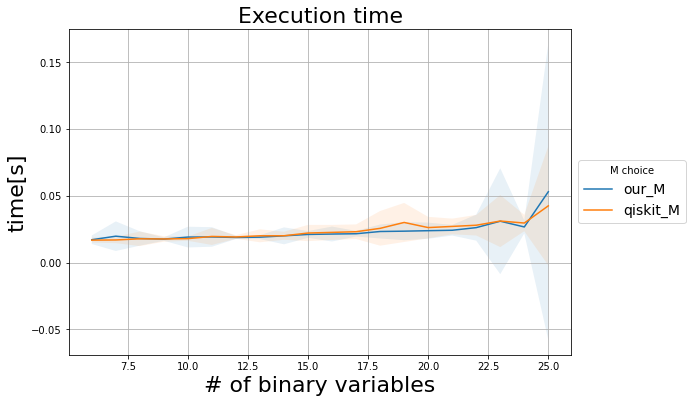

In [115]:

def statistics_time_solver(data):
    avg = np.mean(data.time[:,:,:], axis = 1)
    std = np.std(data.time[:,:,:], axis = 1)
    return avg, std

avg_time_solver, std_time_solver = statistics_time_solver(data)

""" outliers = [0, 22, 50, 51, 85, 97]
def statistics_time_solver_outliers(data, outliers):
    n_vars, n_samples, n_M = np.shape(data.is_optimum)
    mask = np.zeros((n_samples))
    big_mask = np.zeros((n_samples, n_M))
    mask[outliers] = 1
    big_mask[outliers] = 1
    avg = np.mean(data.time_solver[:,:,:], axis = 1)
    std = np.std(data.time_solver[:,:,:], axis = 1)
    avg[-1] = np.mean(np.ma.masked_array( data.time_solver[-1,:,:], mask = big_mask), axis = 0)
    std[-1] = np.std(np.ma.masked_array( data.time_solver[-1,:,:], mask = big_mask), axis = 0)
    return avg, std, mask
avg_time_solver, std_time_solver, mask = statistics_time_solver_outliers(data, outliers) """

fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Execution time', fontsize = 22)
ax1.set_xlabel('# of binary variables', fontsize = 22)
ax1.set_ylabel('time[s]', fontsize = 22)
for i in range(len(M_strategies)):
    if plot_M[i]:
        plt.plot(data.bvars, avg_time_solver[:,i], label=M_strategies[i])
        plt.fill_between(data.bvars, avg_time_solver[:,i] - std_time_solver[:,i], avg_time_solver[:,i] + std_time_solver[:,i], alpha=.1)
        """ for var_idx in range(len(data.bvars)):
            y = data.time[var_idx,:,i]
            x = data.bvars[var_idx] * np.ones((len(y)))
            plt.scatter(x, y, color = colors[i], alpha=.3) """
plt.grid()
#plt.ylim(0, 10)
#plt.yscale("log")
ax1.legend(title = 'M choice', fontsize = 14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

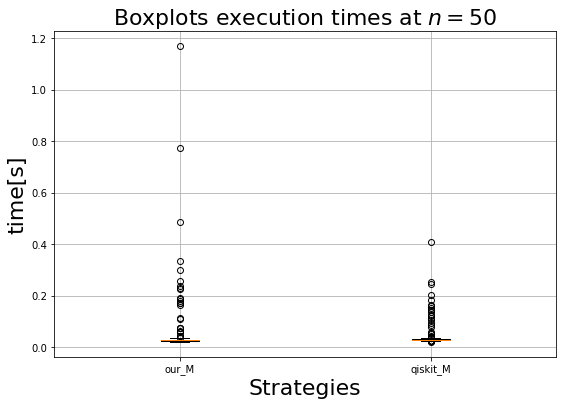

Our median:	0.0279
Qiskit median:	0.0302


In [116]:
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Boxplots execution times at $n=50$', fontsize = 22)
ax1.set_xlabel('Strategies', fontsize = 22)
ax1.set_ylabel('time[s]', fontsize = 22)
ax1.boxplot(data.time[-1,:,:2], labels = M_strategies[:2])
#plt.ylim(0,10)
plt.grid()
plt.show()

print(f"Our median:\t{np.round( np.median(data.time[-1,:,0]) , 4)}")
print(f"Qiskit median:\t{np.round( np.median(data.time[-1,:,1]) , 4)}")

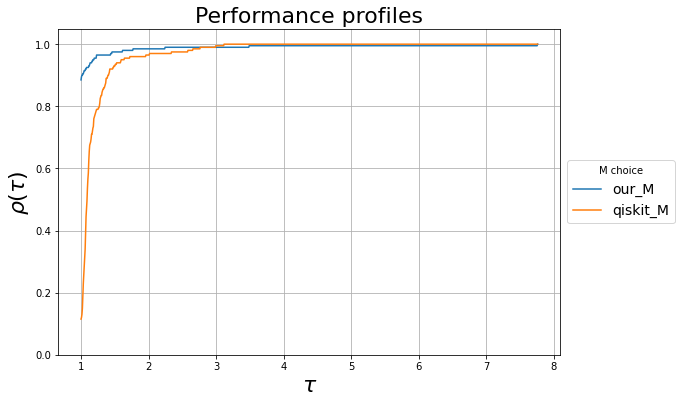

In [10]:
def performance_profile(times, resolution = 1000, solvers = None):
    # deal with computing only for a subset of solvers
    if solvers is None:
        solvers = np.arange(np.shape(times)[1])
    else:
        times = times[:, solvers]

    n_samples, n_M = np.shape(times)
    r = times/np.min(times, axis = 1)[:, np.newaxis]
    tau_array = np.linspace(1, np.max(r), num = resolution)
    rho = np.ndarray((resolution, n_M))
    for tau_i in range(resolution):
        rho[tau_i, :] = np.count_nonzero( r <= tau_array[tau_i], axis = 0)
    rho = rho/n_samples
    return tau_array, rho, solvers

taus, rho, solvers = performance_profile(data.time[-1], solvers = [0,1])

fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Performance profiles', fontsize = 22)
ax1.set_xlabel(r'$ \tau $', fontsize = 22)
ax1.set_ylabel(r'$\rho( \tau )$', fontsize = 22)
for i in solvers:
    if plot_M[i]:
        plt.plot(taus, rho[:,i], label=M_strategies[i])
plt.grid()
plt.ylim(0, 1.05)
ax1.legend(title = 'M choice', fontsize = 14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Gaps

In [8]:
def statistics_gaps(gap):
    avg = np.mean(gap[:,:,:], axis = 1)
    std = np.std(gap[:,:,:], axis = 1)
    return avg, std

def statistics_gaps_outliers(gap):
    avg_ob = np.mean(gap[:,:,0,:], axis = 1)
    std_ob = np.std(gap[:,:,0,:], axis = 1)

    gap_obj = gap[:,:,1,:]
    n_vars, n_sample, n_M = np.shape(gap_obj)
    avg_tot, std_tot = np.zeros((n_vars, n_M)), np.zeros((n_vars, n_M))
    mask = np.zeros((n_vars, n_sample))
    # discard whatever is 5 times higher than average
    for i in range(n_vars):
        mean = np.mean(gap_obj[i, :, 0])
        outliers = list( np.where( gap_obj[i, :, 0] > 5*mean )[0] )
        mask[i, outliers] = 1
        for M_idx in range(n_M):
            masked = np.ma.masked_array(gap_obj[i,:,M_idx], mask = mask[i])
            avg_tot[i, M_idx] = np.mean(masked)
            std_tot[i, M_idx] = np.std(masked)
    return avg_tot, std_tot, mask


avg_gap, std_gap = statistics_gaps(data.gap)
#avg_gap_woout, std_gap_woout, mask = statistics_gaps_outliers(data.gap[:-2]) # woout stands for "without outliers"


### Gaps quantum simulations

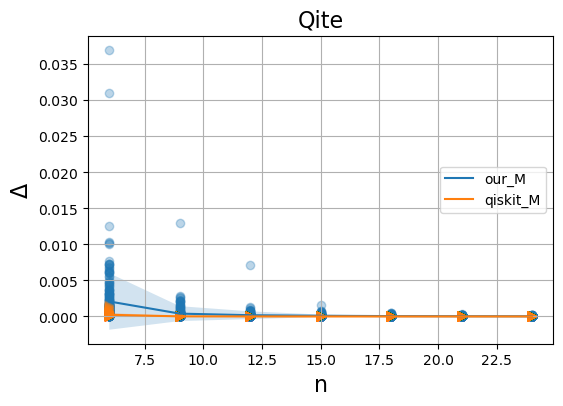

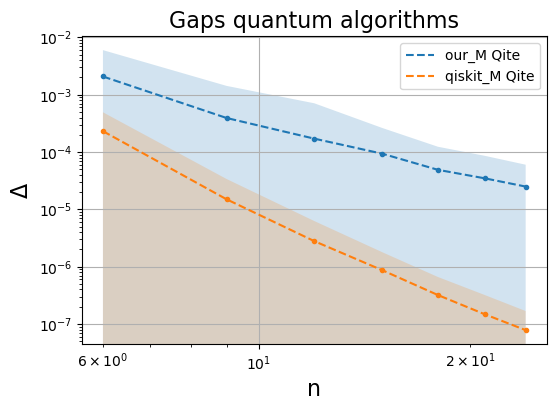

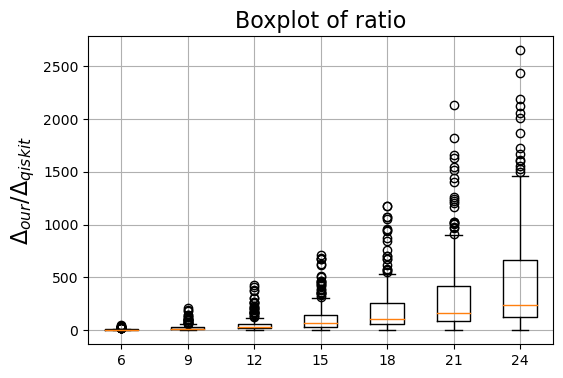

In [11]:
avg_gap_qite, std_gap_qite = statistics_gaps(data.gap_norm)
avg_gap_adiabatic, std_gap_adiabatic = statistics_gaps(data.gap_minimal)

endpt_adiab = 10
endpt_qite = 22
""" endpt_adiab = 5
endpt_qite = 11 """

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Qite', fontsize = 16)
ax1.set_xlabel('n', fontsize = 16)
ax1.set_ylabel('$\Delta$', fontsize = 16)
for i in range(len(M_strategies)):
    if plot_M[i]:
        plt.plot(data.bvars, avg_gap_qite[:,i], label=M_strategies[i],  color = colors[i])
        plt.fill_between(data.bvars, avg_gap_qite[:,i] - std_gap_qite[:,i], avg_gap_qite[:,i] + std_gap_qite[:,i], alpha=.2)
        for var_idx in range(len(data.bvars)):
            y = data.gap_norm[var_idx,:,i]
            x = data.bvars[var_idx] * np.ones((len(y)))
            plt.scatter(x, y, color = colors[i], alpha=.3, marker = markers[i])
plt.grid()
#plt.yscale("log")
#plt.ylim(-.005, .01)
ax1.legend(fontsize = 10, loc='center right')

""" var = 4
mask = data.gap_norm[var,:,0] - data.gap_norm[var,:,2] > 0
print(np.ma.array(data.gap_norm[var,:,0] - data.gap_norm[var,:,2], mask = mask)) """


""" fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Adiabatic', fontsize = 16)
ax1.set_xlabel('n', fontsize = 16)
ax1.set_ylabel('$\Delta_{min}$', fontsize = 16)
for i in range(len(M_strategies)):
    if plot_M[i]:
        plt.plot(data.bvars[:endpt_adiab], avg_gap_adiabatic[:endpt_adiab,i], label=M_strategies[i],  color = colors[i])
        plt.fill_between(data.bvars[:endpt_adiab], avg_gap_adiabatic[:endpt_adiab,i] - std_gap_adiabatic[:endpt_adiab,i], avg_gap_adiabatic[:endpt_adiab,i] + std_gap_adiabatic[:endpt_adiab,i], alpha=.2)
        for var_idx in range(len(data.bvars[:endpt_adiab])):
            y = data.gap_minimal[var_idx,:,i]
            x = data.bvars[var_idx] * np.ones((len(y)))
            plt.scatter(x, y, color = colors[i], alpha=.3, marker = markers[i])
plt.grid()
#plt.yscale("log")
plt.ylim(-.02, .2)
ax1.legend(fontsize = 10, loc='center right')
plt.show() """


fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Gaps quantum algorithms', fontsize = 16)
ax1.set_xlabel('n', fontsize = 16)
ax1.set_ylabel('$\Delta$', fontsize = 16)
for i in range(len(M_strategies)):
    if plot_M[i]:
        #plt.plot(data.bvars[:endpt_adiab], avg_gap_adiabatic[:endpt_adiab,i], label=M_strategies[i]+" Adiab",  color = colors[i])
        plt.plot(data.bvars, avg_gap_qite[:,i], "--", label=M_strategies[i]+" Qite",  color = colors[i])
        plt.plot(data.bvars, avg_gap_qite[:,i], ".",  color = colors[i])
        #plt.fill_between(data.bvars, avg_gap_adiabatic[:,i] - std_gap_adiabatic[:,i], avg_gap_adiabatic[:,i] + std_gap_adiabatic[:,i], alpha=.2)
        plt.fill_between(data.bvars, avg_gap_qite[:,i] - std_gap_qite[:,i], avg_gap_qite[:,i] + std_gap_qite[:,i], alpha=.2)
        """ for var_idx in range(len(data.bvars)):
            y = data.gap_minimal[var_idx,:,i]
            x = data.bvars[var_idx] * np.ones((len(y)))
            plt.scatter(x, y, color = colors[i], alpha=.3, marker = markers[i]) """
plt.grid()
plt.yscale("log")
plt.xscale("log")
ax1.legend(fontsize = 10, loc='upper right')
plt.show()

""" # better to look at mean of ratios than at ratio of means
# As an example consider Delta_qiskit = [1, 0.1, 0.1] while Delta_our = [1, 1, 1]. Ratio of means gives 2.5 while Mean of ratios gives 7, which is more representative
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Mean of ratios', fontsize = 16)
ax1.set_xlabel('# of binary variables', fontsize = 16)
ax1.set_ylabel('$\Delta_{our} / \Delta_{qiskit}$', fontsize = 16)
#plt.plot(data.bvars[:endpt_adiab], np.mean(data.gap_minimal[:endpt_adiab,:,0]/data.gap_minimal[:endpt_adiab,:,1], axis = 1), label="ratio_adiabatic") 
plt.plot(data.bvars[:endpt_qite], np.mean(data.gap_norm[:endpt_qite,:,0]/data.gap_norm[:endpt_qite,:,1], axis = 1), label="ratio_qite")  
plt.grid()
#plt.ylim(0,80)
ax1.legend(title = 'M choice', fontsize = 10, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
 """
_, n_samples, _ = np.shape(data.is_feasible)
indexes_to_plot = list(np.arange(7))
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Boxplot of ratio', fontsize = 16)
#ax1.set_xlabel('Strategies', fontsize = 16)
ax1.set_ylabel('$\Delta_{our} / \Delta_{qiskit}$', fontsize = 16)
ax1.boxplot(np.swapaxes(data.gap_norm[indexes_to_plot,:,0]/data.gap_norm[indexes_to_plot,:,1], axis1=0, axis2=1), labels = data.bvars[indexes_to_plot])
#plt.axhline(10)
#plt.ylim(0,500)
plt.grid()
plt.show()

### Fit of gaps

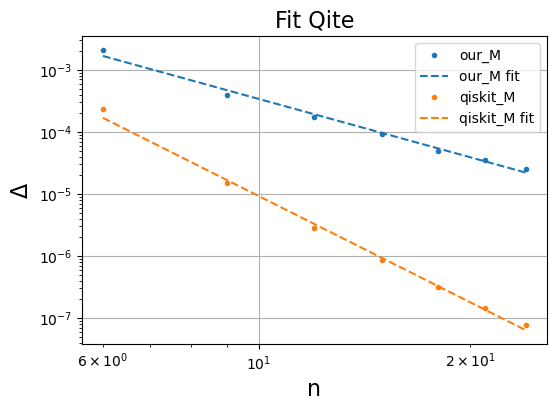

Our fit: 0.45 x^-3.12
a:	0.449 \pm 2.089
b:	-3.121 \pm 1.665

Qiskit fit: 4.46 x^-5.68
a:	4.459 \pm 13.4
b:	-5.683 \pm 1.127



In [12]:
f_pl = lambda x, a, b : a*x**b
f_exp = lambda x, a, b : a*b**x
funct = f_pl

n_parameters = 2
startpoint = 0
n_M = 2

coef = np.ndarray((n_parameters, n_M))
coef_cov = np.ndarray((n_parameters, n_parameters, n_M))
coef_err = np.ndarray((n_parameters, n_M))
for i in range(n_M):
    coef[:,i], coef_cov[...,i] = sp.optimize.curve_fit(funct, data.bvars[startpoint:], avg_gap_qite[startpoint:,i],
                                sigma = std_gap_qite[startpoint:,i],
                                absolute_sigma = True)
    coef_err[:,i] = np.sqrt(np.diag(coef_cov[...,i]))
# sigma in curve_fit gives the uncertainty in ydata

def RSS(x, y, f):
    return np.sum( np.square(y - f(x)) )

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Fit Qite', fontsize = 16)
ax1.set_xlabel('n', fontsize = 16)
ax1.set_ylabel('$\Delta$', fontsize = 16)
for i in range(n_M):
    if plot_M[i]:
        #plt.plot(data.bvars[:10], avg_gap_adiabatic[:10,i], label=M_strategies[i]+" Adiab",  color = colors[i])
        plt.plot(data.bvars, avg_gap_qite[:,i], ".", label=M_strategies[i],  color = colors[i])
        #plt.fill_between(data.bvars[:endpt_qite], avg_gap_qite[:endpt_qite,i] - std_gap_qite[:endpt_qite,i],
        #                 avg_gap_qite[:endpt_qite,i] + std_gap_qite[:endpt_qite,i], alpha=.2,  color = colors[i])
        plt.plot(data.bvars, funct(data.bvars, *coef[:,i]), "--", color = colors[i], label=M_strategies[i]+" fit")
plt.grid()
plt.xscale("log")
plt.yscale("log")
#plt.ylim(1e-5, 3e-2)
#plt.xlim(9, 26)
ax1.legend(fontsize = 10, loc='upper right')
plt.show() 


word = ["Our", "Qiskit", "Optimal"]
for i in range(n_M):
    print(f"{word[i]} fit: {np.round(coef[0,i], 2)} x^{np.round(coef[1,i], 2)}")
    print(f"a:\t{np.round(coef[0,i], 3)} \pm {np.round(coef_err[0,i], 3) }")
    print(f"b:\t{np.round(coef[1,i], 3)} \pm {np.round(coef_err[1,i], 3) }\n")
    #r = RSS( data.bvars[startpoint:endpoint], avg_gap_qite[startpoint:endpoint,i], lambda x : funct(x, *coef[:,i]))
    #print(f"RSS (wrt mean) value {np.round(r, 7)}")

[10]


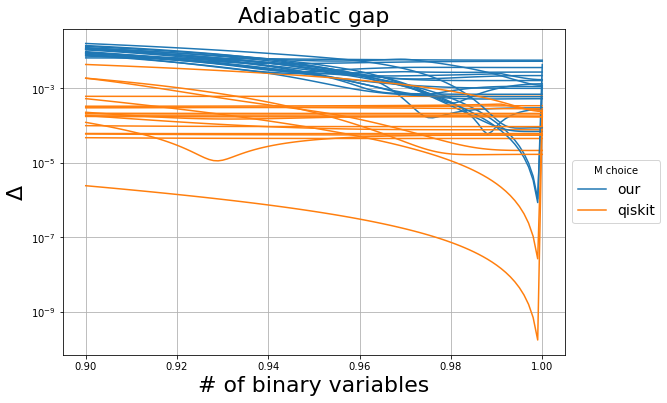

[0.999, 0.976, 0.98, 0.988, 0.988, 0.997, 1.0, 0.9470000000000001, 1.0, 0.999, 0.9450000000000001, 0.973, 0.988, 1.0, 0.995, 0.972, 1.0, 1.0, 0.95, 0.987]
0.9841999999999999
[0.999, 0.929, 0.9, 1.0, 0.99, 0.997, 1.0, 1.0, 1.0, 0.999, 0.924, 0.932, 0.936, 1.0, 0.985, 0.952, 1.0, 1.0, 0.965, 0.986]
0.9747


In [16]:
_, n_samples, _, n_alphas = np.shape(data.gap_minimal)
alphas = np.linspace(.9, 1, n_alphas)

fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title('Adiabatic gap', fontsize = 22)
ax1.set_xlabel('# of binary variables', fontsize = 22)
ax1.set_ylabel('$\Delta$', fontsize = 22)
for s in range(n_samples-1):
    plt.plot(alphas, data.gap_minimal[0, s, 0, :], color = colors[0])
    plt.plot(alphas, data.gap_minimal[0, s, 1, :], color = colors[1])
plt.plot(alphas, data.gap_minimal[0, n_samples-1, 0, :], label="our", color = colors[0])
plt.plot(alphas, data.gap_minimal[0, n_samples-1, 1, :], label="qiskit", color = colors[1])
plt.grid()
#plt.ylim(0,.04)
plt.yscale("log")
ax1.legend(title = 'M choice', fontsize = 14, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

min_our = []
min_qiskit = []
for s in range(n_samples):
    min_our.append( alphas[np.argmin( data.gap_minimal[0, s, 0, :] )] )
    min_qiskit.append( alphas[np.argmin( data.gap_minimal[0, s, 1, :] )] )
print(min_our)
print(np.mean(min_our))
print(min_qiskit)
print(np.mean(min_qiskit))

In [2]:
file = open("../data/PO_part3.txt", "rb")
data_base = pickle.load(file)
file.close()

file = open("../data/PO_part3_extension.txt", "rb")
data_extend = pickle.load(file)
file.close()

bvars_extend = [24]

def glue_datas_bybvars(data_base, data_extend, bvars_extend):
    break_idx = len(bvars_extend)
    _, n_samples, n_M_strategies = np.shape(data_extend.is_optimum)
    bvars = np.append(data_base.bvars, bvars_extend)
    data = Datas(bvars, n_samples, n_M_strategies)
    data.gap[:- break_idx ] = data_base.gap
    data.gap[- break_idx :] = data_extend.gap
    data.gap_norm[:- break_idx ] = data_base.gap_norm
    data.gap_norm[- break_idx :] = data_extend.gap_norm
    data.gap_minimal[:- break_idx ] = data_base.gap_minimal
    data.gap_minimal[- break_idx :] = data_extend.gap_minimal
    data.fval[:- break_idx ] = data_base.fval
    data.fval[- break_idx :] = data_extend.fval
    data.M[:- break_idx ] = data_base.M
    data.M[- break_idx :] = data_extend.M
    data.is_optimum[:- break_idx ] = data_base.is_optimum
    data.is_optimum[- break_idx :] = data_extend.is_optimum
    data.is_feasible[:- break_idx ] = data_base.is_feasible
    data.is_feasible[- break_idx :] = data_extend.is_feasible
    data.relative_error[:- break_idx ] = data_base.relative_error
    data.relative_error[- break_idx :] = data_extend.relative_error
    data.absolute_error[:- break_idx ] = data_base.absolute_error
    data.absolute_error[- break_idx :] = data_extend.absolute_error
    data.n_violations[:- break_idx ] = data_base.n_violations
    data.n_violations[- break_idx :] = data_extend.n_violations
    data.max_violation[:- break_idx ] = data_base.max_violation
    data.max_violation[- break_idx :] = data_extend.max_violation
    data.time[:- break_idx ] = data_base.time
    data.time[- break_idx :] = data_extend.time
    return data

def glue_datas_Mmethod(data_base, data_extend):
    break_idx = 1
    _, n_samples, n_M_strategies = np.shape(data_base.is_optimum)
    data = Datas(data_base.bvars, n_samples, n_M_strategies + 1)
    data.gap[..., :- break_idx ] = data_base.gap
    data.gap[..., - break_idx :] = data_extend.gap
    data.gap_norm[...,:- break_idx ] = data_base.gap_norm
    data.gap_norm[...,- break_idx :] = data_extend.gap_norm
    data.gap_minimal[...,:- break_idx ] = data_base.gap_minimal
    data.gap_minimal[...,- break_idx :] = data_extend.gap_minimal
    data.fval[...,:- break_idx ] = data_base.fval
    data.fval[...,- break_idx :] = data_extend.fval
    data.M[...,:- break_idx ] = data_base.M
    data.M[...,- break_idx :] = data_extend.M
    data.is_optimum[...,:- break_idx ] = data_base.is_optimum
    data.is_optimum[...,- break_idx :] = data_extend.is_optimum
    data.is_feasible[...,:- break_idx ] = data_base.is_feasible
    data.is_feasible[...,- break_idx :] = data_extend.is_feasible
    data.relative_error[...,:- break_idx ] = data_base.relative_error
    data.relative_error[...,- break_idx :] = data_extend.relative_error
    data.absolute_error[...,:- break_idx ] = data_base.absolute_error
    data.absolute_error[...,- break_idx :] = data_extend.absolute_error
    data.n_violations[...,:- break_idx ] = data_base.n_violations
    data.n_violations[...,- break_idx :] = data_extend.n_violations
    data.max_violation[...,:- break_idx ] = data_base.max_violation
    data.max_violation[...,- break_idx :] = data_extend.max_violation
    data.time[...,:- break_idx ] = data_base.time
    data.time[...,- break_idx :] = data_extend.time
    return data

data = glue_datas_bybvars(data_base, data_extend, bvars_extend)
#data = glue_datas_Mmethod(data_base, data_extend)

file = open("../data/PO_part3_final.txt", "wb")
pickle.dump(data, file)
file.close()